In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#reading dataset
df=pd.read_csv("C:\\Users\\bharg\\Downloads\\spam_ham_dataset.csv.zip")

In [3]:
df.shape

(5171, 4)

In [6]:
df.columns

Index(['Unnamed: 0', 'label', 'text', 'label_num'], dtype='object')

In [3]:
df.head(10)

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0
5,2949,ham,Subject: ehronline web address change\r\nthis ...,0
6,2793,ham,Subject: spring savings certificate - take 30 ...,0
7,4185,spam,Subject: looking for medication ? we ` re the ...,1
8,2641,ham,Subject: noms / actual flow for 2 / 26\r\nwe a...,0
9,1870,ham,"Subject: nominations for oct . 21 - 23 , 2000\...",0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [7]:
!pip install wordcloud

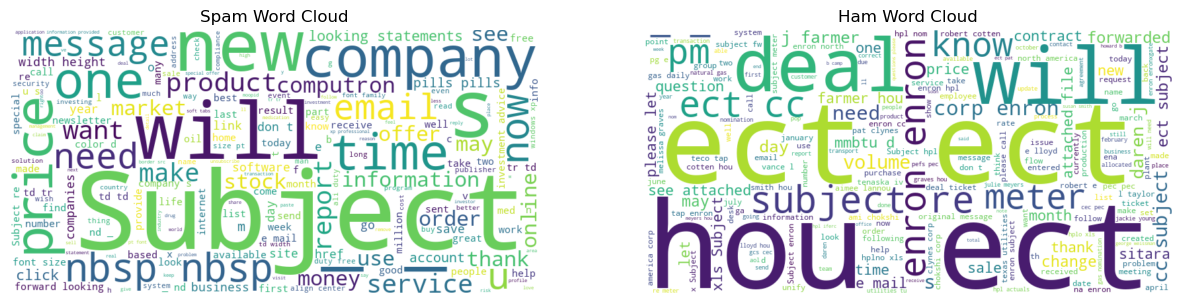

In [3]:
from wordcloud import WordCloud

# Word cloud for spam messages
spam_text = " ".join(df[df['label'] == 'spam']['text'].values)
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_text)

# Word cloud for ham messages
ham_text = " ".join(df[df['label'] == 'ham']['text'].values)
ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_text)

# Display the word clouds
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(spam_wordcloud, interpolation='bilinear')
ax[0].axis('off')
ax[0].set_title('Spam Word Cloud')
ax[1].imshow(ham_wordcloud, interpolation='bilinear')
ax[1].axis('off')
ax[1].set_title('Ham Word Cloud')
plt.show()

In [4]:
#missing values
df.isnull().sum()

Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64

In [5]:
#check for duplicates
df.duplicated().sum()

0

In [3]:
df=df.drop_duplicates()

In [4]:
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0','label'], inplace=True)

In [5]:
df.rename(columns={'label_num':'target'},inplace=True)
df.sample(5)

,text,target
2625,Subject: april - - - flexible katy gas\r\nfyi ...,0
3633,Subject: enron net works\r\nit is becoming inc...,0
2822,"Subject: hpl noms for june 30 , 2000\r\n( see ...",0
3813,Subject: fwd : we supply all . vlagr $ vali : ...,1
408,"Subject: koch three rivers , # 6722\r\ni spoke...",0


In [11]:
df.shape

(5171, 2)

In [12]:
df['target'].value_counts()

0    3672
1    1499
Name: target, dtype: int64

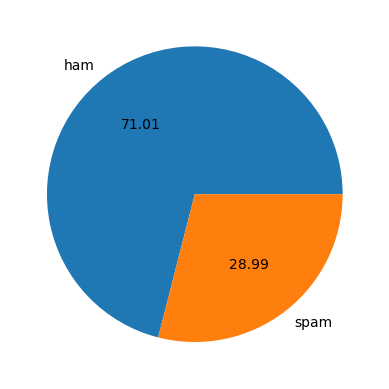

In [13]:
plt.pie(df['target'].value_counts(),labels=['ham','spam'],autopct="%0.2f")
plt.show()#data is imbalanced

# Text preprocessing

In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download required NLTK data files (only need to run once)
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

# Preprocessing function
def preprocess_text(text):
    # Remove special characters and digits
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenization
    words = word_tokenize(text)
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return words

# Apply preprocessing to the 'text' column
df['preprocess_text'] = df['text'].apply(preprocess_text)

# Prepare the data for Word2Vec
sentences = df['preprocess_text'].tolist()

In [10]:
df.head()

,text,target,preprocess_text
0,Subject: enron methanol ; meter # : 988291\r\n...,0,"[subject, enron, methanol, meter, follow, note..."
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,"[subject, hpl, nom, january, see, attached, fi..."
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,"[subject, neon, retreat, ho, ho, ho, around, w..."
3,"Subject: photoshop , windows , office . cheap ...",1,"[subject, photoshop, window, office, cheap, ma..."
4,Subject: re : indian springs\r\nthis deal is t...,0,"[subject, indian, spring, deal, book, teco, pv..."


# Vectorization

In [7]:
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, classification_report, ConfusionMatrixDisplay

In [8]:
# Train a Word2Vec model
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

In [9]:
# Function to get the average Word2Vec vector for a text
def text_vector(text, model):
    # Filter out words not in the model's vocabulary
    words = [word for word in text if word in model.wv]
    if len(words) == 0:
        return np.zeros(model.vector_size)
    # Average the vectors of the words in the text
    return np.mean([model.wv[word] for word in words], axis=0)

In [10]:
# Apply the function to the processed texts
df['vector'] = df['preprocess_text'].apply(lambda x: text_vector(x, model))

In [11]:
# Extract vectors and target column
X = np.vstack(df['vector'].values)
y = df['target'].values

# Splitting the data

In [12]:
# Splitting into train and test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4136, 100) (4136,)
(1035, 100) (1035,)


In [13]:
X

array([[-0.04789295,  0.31181234,  0.18550445, ..., -0.86831516,
        -0.12611566,  1.0319209 ],
       [-0.19350824, -0.08301307, -0.3050275 , ..., -1.258805  ,
        -0.9373676 ,  0.26772818],
       [-0.10136834,  0.64879614, -0.03617497, ..., -0.23137885,
         0.02804198,  0.85967565],
       ...,
       [-0.30006722,  0.13545993,  0.19360581, ..., -0.97008735,
        -0.08332596,  0.71426195],
       [-0.15450434,  0.35191092,  0.0221939 , ..., -0.7235107 ,
        -0.14863196,  0.703893  ],
       [-0.4782171 ,  0.91604024, -0.11901652, ..., -0.08907201,
        -0.04744433,  0.9352527 ]], dtype=float32)

In [14]:
y

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

# Buidling model

In [15]:
# Train a simple classifier
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

In [16]:
# Predict and evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

In [17]:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9671497584541063
Precision: 0.9218241042345277
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       742
           1       0.92      0.97      0.94       293

    accuracy                           0.97      1035
   macro avg       0.95      0.97      0.96      1035
weighted avg       0.97      0.97      0.97      1035



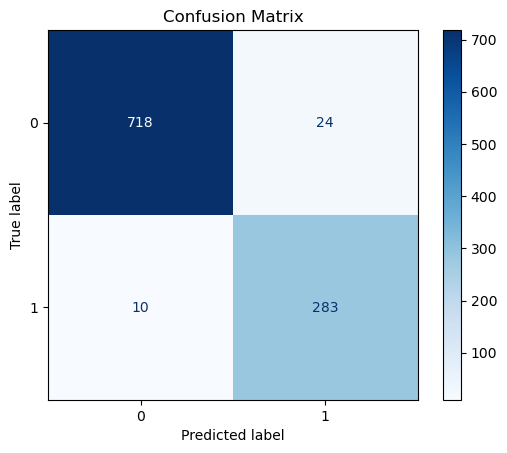

In [18]:
# Plotting the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion Matrix")
plt.show()

In [20]:
from sklearn.svm import SVC
# Create an SVM classifier
svm_clf = SVC()
# Fit the classifier to the training data
svm_clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9690821256038648
Precision: 0.9278688524590164
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       742
           1       0.93      0.97      0.95       293

    accuracy                           0.97      1035
   macro avg       0.96      0.97      0.96      1035
weighted avg       0.97      0.97      0.97      1035



# Hyper parameter Tunings

In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, make_scorer

# Define parameter grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}

# Instantiate Logistic Regression model
logreg = LogisticRegression(max_iter=1000)

# Define scoring metric (e.g., accuracy)
scoring = {'accuracy': make_scorer(accuracy_score), 'precision': make_scorer(precision_score)}

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring=scoring, refit='accuracy', verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print best parameters and best score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Evaluate best model on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Accuracy on test set: {accuracy}")
print(f"Precision on test set: {precision}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\bharg\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bharg\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bharg\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bharg\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision 

Best parameters found: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation accuracy: 0.9700191016946181
Accuracy on test set: 0.9719806763285024
Precision on test set: 0.9370860927152318
